# Star Wars Retrieval-Augmented Generation (RAG) System

This Jupyter Notebook demonstrates a Retrieval-Augmented Generation (RAG) system designed to answer questions about the Star Wars universe. The system combines a retriever that fetches relevant documents from a knowledge base with a language model that generates answers based on these documents. The core components include embeddings for vector representations, a FAISS vector store for efficient retrieval, and a conversational retrieval chain.

In [142]:
class Settings:
    topP = 4
    temperature = 0.7
    questions = [
        "How do Luke and Rey's arcs compare?",
        "What are the main plot differences between the original and sequel trilogies?",
        "How do Darth Vader and Kylo Ren differ?",
        "How have special effects evolved from the original to the new movies?",
        "What are common criticisms of the sequels compared to the originals?",
        "How did the original trilogy influence culture compared to the sequels?",
        "What themes are explored in the original and sequel trilogies?"
    ]

## 0. Installation
Ensure you have the following libraries installed:


* `langchain`
* `faiss-gpu`
* `openai`

To install, uncomment the cell below

In [143]:
!pip install -q transformers
!pip install -q "datasets<=2.18.0"
!pip install -q sentence-transformers
!pip install -q langchain
!pip install -q langchain_community
!pip install -q langchainhub
!pip install -q torch
!pip install -q faiss-gpu
!pip install -q "bitsandbytes<=0.40.2"

## 1. Import Statements
This section imports the necessary libraries:

* `OpenAI`: Interface for OpenAI's language models.
* `ConversationalRetrievalChain`: Combines LLM, retriever, and memory for conversational QA.
* `FAISS`: Library for efficient similarity search and clustering of dense vectors.
* `OpenAIEmbeddings`: Creates embeddings using OpenAI models.
* `ConversationBufferMemory`: Stores and manages conversation history.


In [144]:
# Import HuggingFace embeddings for creating vector representations
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

# Import HuggingFace pipeline for language model processing
from langchain_community.llms import HuggingFacePipeline

# Import text splitter to split text into smaller chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Import FAISS for efficient similarity search and clustering of dense vectors
from langchain_community.vectorstores import FAISS

# Import RetrievalQA for combining LLM, retriever, and memory for QA tasks
from langchain.chains import RetrievalQA

# Import PromptTemplate for structuring prompts
from langchain.prompts import PromptTemplate

# Import matplotlib for visualization
import matplotlib.pyplot as plt

We are going to use the imdb dataset provided by huggingface. The dataset is easy to use and to load.

## 2. Load Data
The imdb datset comes with 3 seperate sets of data as can be seen above: train, test, and unsupervised. For our applicaiton we only want the text to give the LLM to train. It does not have to be labeled so we can treat the data as all unsupervised. We will combine all the data into a single dataset.

In [145]:
from datasets import load_dataset

# Load the IMDB dataset from the HuggingFace datasets library
imdb_dataset = load_dataset("imdb")

# Print available splits to ensure the dataset is loaded correctly
print(imdb_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [146]:
from datasets import concatenate_datasets

# Combine the train, test, and unsupervised splits into a single dataset
combined_dataset = concatenate_datasets([imdb_dataset['train'], imdb_dataset['test'], imdb_dataset['unsupervised']])

# Print the combined dataset to ensure it has been merged correctly
print(combined_dataset)

# Print the first entry of the combined dataset as a sample
print(combined_dataset[2])

Dataset({
    features: ['text', 'label'],
    num_rows: 100000
})
{'text': "If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />", 'label': 0}


We want to narrow down our dataset to just one topic. We decided for this project to make that topic Star Wars. There are in total 9 movies: 3 classic movies, 3 movies from the early 2000s and 3 recent movies.

In [147]:
import re

# Define the movie you want to filter by
specific_movie = "Star Wars"

# Define a function to filter texts containing the specific word or phrase
def filter_texts(example):
    return bool(re.search(rf'\b{specific_movie}\b', example['text'], re.IGNORECASE))

# Apply the filter to the combined dataset
filtered_dataset = combined_dataset.filter(filter_texts)

# Verify the filtered dataset by printing it
print(filtered_dataset)

# Print the first entry of the filtered dataset as a sample
target_sample = filtered_dataset[15]["text"]
keyword_index = target_sample.lower().find(" star ")
search_offset = 30

target_sample[
    max(keyword_index - search_offset, 0):
    min(len(target_sample), keyword_index + search_offset)
]

Dataset({
    features: ['text', 'label'],
    num_rows: 618
})


"ctly like a tuskan raider from star wars. I'll call him Tusk"

As mentioned above the domain for our project is Star Wars. Star Wars is now a large universe with movies, television shows, theme park rides, books, comics, and toys. It was originally 3 movies that redefinded the genre of science fiction movies, and was the introduction of modern special effects.

The dataset we are using is the IMDB dataset provided by `HuggingFace`. Considering the dataset is limited to movie reviews, the rest of the Star Wars universe is excluded except for the 9 movies. The 9 movies vary in age. It is plausible that the older movies have more reviews and will provide better context for LLM.

Dataset profiling with a summary of through descriptive statistics can be found below:

The code above performs several profiling tasks on the filtered dataset:

1. Converts the dataset to a pandas DataFrame.
2. Displays the first few rows of the dataset.
3. Provides descriptive statistics for numerical columns.
4. Displays frequency counts for the 'label' column.
5. Checks for missing values.
6. Provides a summary of text lengths for the 'text' column.

In [148]:
import pandas as pd

# Convert the filtered dataset to a pandas DataFrame
df = pd.DataFrame(filtered_dataset)

# Display the first few rows of the dataset
print("Dataset Preview:")
print(df.head())

# Basic Statistics for Numerical Columns
print("\nDescriptive Statistics for Numerical Columns:")
print(df.describe())

# Frequency Counts for Categorical Columns
print("\nFrequency Counts for 'label' Column:")
print(df['label'].value_counts())

# Check for Missing Values
print("\nMissing Values Summary:")
print(df.isnull().sum())

# Custom Function to Summarize Text Data Lengths
def text_length_summary(df, column):
    text_lengths = df[column].apply(len)
    print(f"\nText Length Summary for '{column}':")
    print(f"Count: {len(text_lengths)}")
    print(f"Mean: {text_lengths.mean()}")
    print(f"Median: {text_lengths.median()}")
    print(f"Min: {text_lengths.min()}")
    print(f"Max: {text_lengths.max()}")
    print(f"Standard Deviation: {text_lengths.std()}")
    print(f"Quantiles: {text_lengths.quantile([0.25, 0.5, 0.75])}")
    print(f"Variance: {text_lengths.var()}")
    print(f"Skewness: {text_lengths.skew()}")
    print(f"Kurtosis: {text_lengths.kurt()}")

# Apply the Text Length Summary Function
text_length_summary(df, 'text')

Dataset Preview:
                                                text  label
0  As a kid I did think the weapon the murderer w...      0
1  I have just lost three hours of my life to thi...      0
2  Well, on it's credit side (if it can be said t...      0
3  Anyone who has a remote interest in science fi...      0
4  I can't believe this movie managed to get such...      0

Descriptive Statistics for Numerical Columns:
            label
count  618.000000
mean    -0.237864
std      0.834851
min     -1.000000
25%     -1.000000
50%      0.000000
75%      1.000000
max      1.000000

Frequency Counts for 'label' Column:
label
-1    306
 1    159
 0    153
Name: count, dtype: int64

Missing Values Summary:
text     0
label    0
dtype: int64

Text Length Summary for 'text':
Count: 618
Mean: 1934.7459546925566
Median: 1461.5
Min: 246
Max: 9420
Standard Deviation: 1382.7775369001813
Quantiles: 0.25     926.25
0.50    1461.50
0.75    2447.50
Name: text, dtype: float64
Variance: 1912073.71655573

The following cell performs the following tasks:

1. Combines all text data into a single string.
2. Performs a word count analysis using the `Counter` from the collections module.
3. Generates and displays a word cloud using the `WordCloud` class from the wordcloud module.

Counter({'the': 10958, 'of': 5415, 'a': 5218, 'and': 5088, 'to': 4465, 'is': 3252, 'in': 2972, 'that': 2368, 'I': 2130, '/><br': 1994, 'it': 1817, 'this': 1780, 'was': 1579, 'as': 1530, 'with': 1405, 'for': 1388, 'The': 1339, 'but': 1121, 'are': 1096, 'on': 1027, 'movie': 958, 'have': 950, 'be': 926, 'not': 868, 'you': 860, 'film': 837, 'like': 805, 'from': 791, 'one': 755, 'they': 749, 'his': 725, 'at': 724, 'all': 717, 'by': 704, 'Star': 680, 'or': 637, 'an': 626, 'he': 606, 'has': 561, 'so': 557, 'who': 550, 'just': 548, 'about': 522, 'more': 495, 'out': 494, 'some': 491, 'can': 461, 'Wars': 448, 'even': 433, 'if': 421, "it's": 420, 'were': 419, 'good': 414, 'what': 405, 'than': 401, 'when': 400, 'very': 390, 'would': 377, 'up': 375, 'only': 374, 'This': 369, 'which': 366, 'It': 365, 'no': 363, 'my': 358, 'their': 358, 'had': 348, 'really': 343, 'into': 339, 'there': 335, 'most': 333, 'its': 328, 'will': 323, '-': 322, 'other': 312, 'see': 310, 'first': 307, 'get': 297, 'been': 293,

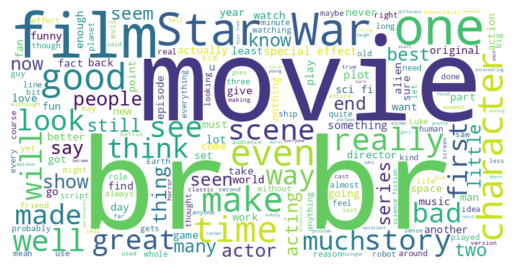

In [149]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text data into a single string
all_text = " ".join(df['text'])

# Perform word count analysis
word_counts = Counter(all_text.split())
print(word_counts)

# Generate and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 3. Embeddings
We utilize `LangChain` to use with our sentence embeddings. Sentence embeddings are fixed-size vector representations of sentences. These vectors capture the semantic meaning of sentences. LangChain simplifies the process of generating and utilizing sentence embeddings by providing seamless integration with pre-trained language models and embedding models. We chose LangChain for its flexabilty working with different LLMs and different vector stores.

This code performs the following tasks:

1. Initializes the `RecursiveCharacterTextSplitter` with specified parameters.
2. Extracts texts from the filtered dataset.
3. Concatenates all texts into a single string.
4. Splits the concatenated text into smaller chunks.
5. Prints the first two text chunks as a sample.

In [150]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Initialize the text splitter with specific chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    length_function=len,
    is_separator_regex=False,
    # separators=[
    #     "\n\n",
    #     ".",
    #     "\n",
    #     " ",
    #     "",
    # ]
)

# Extract texts from the dataset
text = filtered_dataset["text"]

# Concatenate all texts into a single string
concatenated_text = " ".join(text)

# Split the concatenated text into smaller chunks
texts = text_splitter.create_documents([concatenated_text])

# Print the first two text chunks as a sample
print(texts[:2])

[Document(page_content='As a kid I did think the weapon the murderer wielded was cool, however I was a kid and so I was a bit dumb. Even as a dumb kid though the movies plot was stupid and a bit boring when the killer was not using his light knife to kill people. What amazes me is that the movie has a really solid cast in it. What script did they read when agreeing to be in this movie as it is most assuredly boring and only a means to show off a light saber on a very small scale. The plot at times is incomprehensible and the end is totally chaotic. The whole film seems to rotate around aliens and the one weapon. The plot has two kids and some dude having an alien encounter, flash years later and there seems to be a return as it were in the mix. Dead animals and such to be explored and for some reason the one dude gets the weapon of the aliens and proceeds to use it to go on a very light killing spree. Seriously, you just have to wonder why this movie was made, if you are going to have 

## 4. Vector Store

We are using `FAISS` (Facebook AI Similarity Search) for efficient similarity search and clustering of dense vectors. FAISS serves as a vector store for managing and querying the high-dimensional embeddings of our textual data. We chose FAISS for its speed, flexibility and high performance.


The cell below performs the following tasks:

1. Initializes a local file store for caching embeddings.
2. Defines the embedding model ID.
3. Initializes the core embeddings model using `HuggingFace`.
4. Initializes cache-backed embeddings using the core embeddings model and local file store.
5. Creates a FAISS vector store from the text chunks and the embedder.

In [151]:
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore

# Initialize a local file store for caching embeddings
store = LocalFileStore("./cache/")

# Define the embedding model ID
embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

# Initialize the core embeddings model using HuggingFace
core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id
)

# Initialize cache-backed embeddings using the core embeddings model and local file store
embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)

# Create a FAISS vector store from the text chunks and the embedder
vector_store = FAISS.from_documents(texts, embedder)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## 5. Prompt Engineering



This code provided in the cell below performs the following tasks:

1. Defines a query.
2. Generates the embedding vector for the query.
3. Performs a similarity search using the embedding vector, retrieving the top 4 similar documents.
4. Prints the content of the retrieved documents.


In [152]:
# Define the query
query = Settings.questions[0]

# Generate the embedding vector for the query
embedding_vector = core_embeddings_model.embed_query(query)

# Perform a similarity search using the embedding vector, retrieving the top 4 similar documents
docs = vector_store.similarity_search_by_vector(embedding_vector, k=4)

# Print the content of the retrieved documents
for page in docs:
    print(page.page_content)

with Our Heroes: Like I said, this movie gets a lot of crap because of the Ewoks but I think it's kind of cool that while the entire galaxy celebrates the FALL OF THE EMPIRE, our heroes are having their own private party in the woods with each other.<br /><br />All in all this was a great final chapter for our heroes and a fitting end to the STAR WARS story. Perspective is a good thing. Since the release of "Star Wars Episode I: The Phantom Menace", claims and counter-claims of just how Episode's II and III will eventuate has taken the spotlight off the 'original' Star Wars films, making them part of a cohesive whole, rather than segregating the older and new films into separate trilogies. What the new films have done is allow fresh perspectives to be placed on the older films. This new outlook allows us to greater appreciate what has often been viewed as the weakest of the original trilogy: "Return of the Jedi". Often derided for its overly 'cute' factor, ROTJ is in a sense as strong


In [153]:
# Define the query
query = Settings.questions[1]

# Generate the embedding vector for the query
embedding_vector = core_embeddings_model.embed_query(query)

# Perform a similarity search using the embedding vector, retrieving the top 4 similar documents
docs = vector_store.similarity_search_by_vector(embedding_vector, k=4)

# Print the content of the retrieved documents
for page in docs:
    print(page.page_content)

to have some feel of that this is real. I just cant believe in something as silly as the Andromeda future.<br /><br />I just cant understand how anyone under ten could like this crap. I hate sequels, but I still watch them in hopes that there will be one that actually is as good or better than the original.<br /><br />Some are ("Star Wars" sequels, James Bond films, "Godfather" films") but ones like "Sister Act II" are not. It's bad all right, but not in any normal sense. This is bad in its own unique way.<br /><br />Whereas the original had a sense, style, clarity and humorous thrust all its own, "Sister Act II" goes on a completely different tangent than the original. It abandons the old neighborhood from the first movie, adds a bunch of characters that are introduced then forgotten, there are no references to the cop (Nunn) that helped out Whoopi in the original and aside from Sister Mary Patrick (Najimy, always good for a laugh), everyone looks bored beyond belief.<br /><br />The
I

In [154]:
# Define the query
query = Settings.questions[2]

# Generate the embedding vector for the query
embedding_vector = core_embeddings_model.embed_query(query)

# Perform a similarity search using the embedding vector, retrieving the top 4 similar documents
docs = vector_store.similarity_search_by_vector(embedding_vector, k=4)

# Print the content of the retrieved documents
for page in docs:
    print(page.page_content)

as Luke Skywalker in these scenes, and watching him as a fully matured Jedi Knight makes for an unforgettable performance. Also, as iconic as James Earl Jones' voice as Darth Vader is, he is rivaled only by the shriveled, crone-like Emperor, played with deliciously raspy, frightening evil by Ian McDiarmid. The tension between this trio heightens the excitement of this climactic moment, which is appropriately darkly lit and menacingly underscored.<br /><br />The STAR WARS movies have always set standards for special effects, and the technical work in RETURN OF THE JEDI can easily hold a candle to its predecessors. The space battle fights are as exhilarating as always, and the speeder bike chase through the forest is a knockout. Of course, given that this movie was made after A NEW HOPE and THE EMPIRE STRIKES BACK, it probably shouldn't be so surprising that the special effects have reached an even greater level of excellence. The acting is classic STAR WARS fare; Hamill, Harrison Ford
t

In [155]:
# Define the query
query = Settings.questions[3]

# Generate the embedding vector for the query
embedding_vector = core_embeddings_model.embed_query(query)

# Perform a similarity search using the embedding vector, retrieving the top 4 similar documents
docs = vector_store.similarity_search_by_vector(embedding_vector, k=Settings.topP)

# Print the content of the retrieved documents
for page in docs:
    print(page.page_content)

made up by Dogma yet, I'll give a small explanation: the director promises not to use extra light, special effects, extra sound effects... They want to make the story speak for itself and show everything in a natural and realistic way. To some this may seem like the most boring concept ever. I guess many people who like movies like The Lord of the Rings, Star Wars, Spiderman,... movies that are full of special effects, huge scenes and nice visual effects, may not be blown away by this movie. I know that many people may hate the concept, that many people don't want to see this kind of movies, but personally I find this a very welcome concept in a world where everybody seems to feel the need to copy what works, without being original.<br /><br />Kresten has moved from a small Danish island, where his parents farm is, to Copenhagen in order to pursue an excellent career and unconcerned life. He marries his boss's daughter and is sure that he'll become the new boss as soon as his
released 

In [156]:
# Define the query
query = Settings.questions[4]

# Generate the embedding vector for the query
embedding_vector = core_embeddings_model.embed_query(query)

# Perform a similarity search using the embedding vector, retrieving the top 4 similar documents
docs = vector_store.similarity_search_by_vector(embedding_vector, k=4)

# Print the content of the retrieved documents
for page in docs:
    print(page.page_content)

to have some feel of that this is real. I just cant believe in something as silly as the Andromeda future.<br /><br />I just cant understand how anyone under ten could like this crap. I hate sequels, but I still watch them in hopes that there will be one that actually is as good or better than the original.<br /><br />Some are ("Star Wars" sequels, James Bond films, "Godfather" films") but ones like "Sister Act II" are not. It's bad all right, but not in any normal sense. This is bad in its own unique way.<br /><br />Whereas the original had a sense, style, clarity and humorous thrust all its own, "Sister Act II" goes on a completely different tangent than the original. It abandons the old neighborhood from the first movie, adds a bunch of characters that are introduced then forgotten, there are no references to the cop (Nunn) that helped out Whoopi in the original and aside from Sister Mary Patrick (Najimy, always good for a laugh), everyone looks bored beyond belief.<br /><br />The
M

## 6. LLM Quantization

We choose to use GPT-2 from OpenAI as our pre-trained model. GPT-2 is a transformer-based model with 1.5 billion parameters, designed to predict the next word in a sentence, trained on a diverse dataset of internet text. There are other free LLMs to choose from and were considered, such as orca, lamma2,and tiny-bert, but we found GPT-2 integrates well with HuggingFace. We ultimately chose GPT-2 for this project.

In [157]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load pre-trained model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name, padding=True, truncation=True, max_length=100)
model = GPT2LMHeadModel.from_pretrained(model_name)

model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

This code performs the following tasks:

1. Sets the padding token to the EOS token.
2. Creates a retriever from the vector store with a search configuration to retrieve up to 4 relevant documents.
3. Defines a question-answering pipeline using the model and tokenizer.
4. Initializes `HuggingFacePipeline` with the question-answering pipeline.
Loads the latest version of the RAG prompt from the `LangChain` hub.
5. Creates a RetrievalQA chain with the LLM and retriever.


In [158]:
from langchain.llms.huggingface_pipeline import HuggingFacePipeline
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import BitsAndBytesConfig

# Set the padding token to the EOS token
tokenizer.pad_token = tokenizer.eos_token

# Create retriever from the vector store with a search configuration to retrieve up to 4 relevant documents
retriever = vector_store.as_retriever(search_kwargs={"k": 4})

# Define a question-answering pipeline using the model and tokenizer
question_answerer = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=1024,
    num_beams=2,
    num_return_sequences=1,
    top_k=50,
    top_p=Settings.topP,
    temperature=Settings.temperature,
    do_sample=True
)

# Initialize the HuggingFacePipeline with the question-answering pipeline
llm = HuggingFacePipeline(
    pipeline=question_answerer,
    model_kwargs={"temperature": Settings.temperature, "max_length": 100},
)

from langchain.chains import RetrievalQA
from langchain import hub

# Load the latest version of the RAG prompt
prompt = hub.pull("rlm/rag-prompt", api_url="https://api.hub.langchain.com")

# Create a RetrievalQA chain with the LLM and retriever
qa_chain = RetrievalQA.from_chain_type(
    llm, retriever=retriever, chain_type_kwargs={"prompt": prompt}, chain_type="stuff"
)

Test our model with a simple query.

In [159]:
# Define the first test query
question1 = Settings.questions[0]

# Run the query through the QA chain and get the result
result1 = qa_chain.run({"query": question1})

# Print the result of the query
print(result1)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: How do Luke and Rey's arcs compare? 
Context: with Our Heroes: Like I said, this movie gets a lot of crap because of the Ewoks but I think it's kind of cool that while the entire galaxy celebrates the FALL OF THE EMPIRE, our heroes are having their own private party in the woods with each other.<br /><br />All in all this was a great final chapter for our heroes and a fitting end to the STAR WARS story. Perspective is a good thing. Since the release of "Star Wars Episode I: The Phantom Menace", claims and counter-claims of just how Episode's II and III will eventuate has taken the spotlight off the 'original' Star Wars films, making them part of a cohesive whole, rather than segregating the older and new films into separate trilogies. 

We had an idea to add a history to the chat-bot so it could understand the context of previous prompts and give an even better answer but we could never get it to run correctly. We leave the code but we no longer try to use the functions. The problems we found with trying to use history was that it added too many characters to the queries.

This code performs the following tasks:

1. Imports the necessary classes for creating a conversational retrieval chain with memory.
2. Initializes a conversation buffer memory to store chat history.
3. Creates a conversational retrieval chain using the LLM, retriever, and memory.


In [160]:
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

# Initialize conversation buffer memory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

# Create a conversational retrieval chain with LLM, retriever, and memory
chat_qa = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=retriever,
    memory=memory
)

In [161]:
# Define the second test query
question2 = Settings.questions[1]

# Run the query through the QA chain and get the result
result2 = qa_chain.run({"query": question2})

# Print the result of the query
print("\n\n[RESULT]\n\n")
print(result2)



[RESULT]


Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: What are the main plot differences between the original and sequel trilogies? 
Context: to have some feel of that this is real. I just cant believe in something as silly as the Andromeda future.<br /><br />I just cant understand how anyone under ten could like this crap. I hate sequels, but I still watch them in hopes that there will be one that actually is as good or better than the original.<br /><br />Some are ("Star Wars" sequels, James Bond films, "Godfather" films") but ones like "Sister Act II" are not. It's bad all right, but not in any normal sense. This is bad in its own unique way.<br /><br />Whereas the original had a sense, style, clarity and humorous thrust all its own, "Sister Act II" goes on a completely di

In [162]:
# Define the third test query
question3 = Settings.questions[2]

# Run the query through the QA chain and get the result
result3 = qa_chain.run({"query": question3})

# Print the result of the query
print(result3)

Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: How do Darth Vader and Kylo Ren differ? 
Context: as Luke Skywalker in these scenes, and watching him as a fully matured Jedi Knight makes for an unforgettable performance. Also, as iconic as James Earl Jones' voice as Darth Vader is, he is rivaled only by the shriveled, crone-like Emperor, played with deliciously raspy, frightening evil by Ian McDiarmid. The tension between this trio heightens the excitement of this climactic moment, which is appropriately darkly lit and menacingly underscored.<br /><br />The STAR WARS movies have always set standards for special effects, and the technical work in RETURN OF THE JEDI can easily hold a candle to its predecessors. The space battle fights are as exhilarating as always, and the speeder bik

In [163]:
# Define the forth test query
question4 = Settings.questions[3]

# Run the query through the QA chain and get the result
result4 = qa_chain.run({"query": question4})

# Print the result of the query
print(result4)

Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: How have special effects evolved from the original to the new movies? 
Context: made up by Dogma yet, I'll give a small explanation: the director promises not to use extra light, special effects, extra sound effects... They want to make the story speak for itself and show everything in a natural and realistic way. To some this may seem like the most boring concept ever. I guess many people who like movies like The Lord of the Rings, Star Wars, Spiderman,... movies that are full of special effects, huge scenes and nice visual effects, may not be blown away by this movie. I know that many people may hate the concept, that many people don't want to see this kind of movies, but personally I find this a very welcome concept in a world where

In [164]:
# Define the fifth test query
question5 = Settings.questions[4]

# Run the query through the QA chain and get the result
result5 = qa_chain.run({"query": question5})

# Print the result of the query
print(result5)

Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: What are common criticisms of the sequels compared to the originals? 
Context: to have some feel of that this is real. I just cant believe in something as silly as the Andromeda future.<br /><br />I just cant understand how anyone under ten could like this crap. I hate sequels, but I still watch them in hopes that there will be one that actually is as good or better than the original.<br /><br />Some are ("Star Wars" sequels, James Bond films, "Godfather" films") but ones like "Sister Act II" are not. It's bad all right, but not in any normal sense. This is bad in its own unique way.<br /><br />Whereas the original had a sense, style, clarity and humorous thrust all its own, "Sister Act II" goes on a completely different tangent than t

In [165]:
# Define the sixth test query
question6 = Settings.questions[5]

# Run the query through the QA chain and get the result
result6 = qa_chain.run({"query": question6})

# Print the result of the query
print(result6)

Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: How did the original trilogy influence culture compared to the sequels? 
Context: to have some feel of that this is real. I just cant believe in something as silly as the Andromeda future.<br /><br />I just cant understand how anyone under ten could like this crap. I hate sequels, but I still watch them in hopes that there will be one that actually is as good or better than the original.<br /><br />Some are ("Star Wars" sequels, James Bond films, "Godfather" films") but ones like "Sister Act II" are not. It's bad all right, but not in any normal sense. This is bad in its own unique way.<br /><br />Whereas the original had a sense, style, clarity and humorous thrust all its own, "Sister Act II" goes on a completely different tangent tha

In [166]:
# Define the seventh test query
question7 = Settings.questions[6]

# Run the query through the QA chain and get the result
result7 = qa_chain.run({"query": question7})

# Print the result of the query
print(result7)

Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: What themes are explored in the original and sequel trilogies? 
Context: to have some feel of that this is real. I just cant believe in something as silly as the Andromeda future.<br /><br />I just cant understand how anyone under ten could like this crap. I hate sequels, but I still watch them in hopes that there will be one that actually is as good or better than the original.<br /><br />Some are ("Star Wars" sequels, James Bond films, "Godfather" films") but ones like "Sister Act II" are not. It's bad all right, but not in any normal sense. This is bad in its own unique way.<br /><br />Whereas the original had a sense, style, clarity and humorous thrust all its own, "Sister Act II" goes on a completely different tangent than the ori

## 7. Human-based Qualitative Evaluation

In this section, we will perform a qualitative evaluation of the model's responses. Human evaluators will rate the quality of responses generated by the model based on various queries. This will help us understand how well the model performs in a real-world scenario.


In [167]:
# Define a set of evaluation queries
evaluation_queries = Settings.questions

# Generate responses for each query
evaluation_responses = {}
for query in evaluation_queries:
    response = qa_chain.run({"query": query})
    evaluation_responses[query] = response

# Display the responses for human evaluation
for query, response in evaluation_responses.items():
    print(f"Query: {query}\nResponse: {response}\n")

Query: How do Luke and Rey's arcs compare?
Response: Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: How do Luke and Rey's arcs compare? 
Context: with Our Heroes: Like I said, this movie gets a lot of crap because of the Ewoks but I think it's kind of cool that while the entire galaxy celebrates the FALL OF THE EMPIRE, our heroes are having their own private party in the woods with each other.<br /><br />All in all this was a great final chapter for our heroes and a fitting end to the STAR WARS story. Perspective is a good thing. Since the release of "Star Wars Episode I: The Phantom Menace", claims and counter-claims of just how Episode's II and III will eventuate has taken the spotlight off the 'original' Star Wars films, making them part of a cohesive whole, rather than segregat

### Instructions for Human Evaluators

Please read the generated responses to the following queries and rate them on a scale of 1 to 5 based on the following criteria:

1. **Relevance:** How relevant is the response to the query?
2. **Accuracy:** How accurate is the information provided in the response?
3. **Completeness:** Does the response provide a complete answer to the query?
4. **Clarity:** Is the response clear and easy to understand?

For each query, please provide your ratings in the format:
- Query: [Query]
  - Relevance: [1-5]
  - Accuracy: [1-5]
  - Completeness: [1-5]
  - Clarity: [1-5]
  - Additional Comments: [Your comments]

#### Queries and Responses

1. **Query:** What is the Force?
   **Response:** [Generated Response]

2. **Query:** Who is Luke Skywalker's father?
   **Response:** [Generated Response]

3. **Query:** What is the role of Jedi in the Star Wars universe?
   **Response:** [Generated Response]

4. **Query:** Why did Anakin Skywalker turn to the dark side?
   **Response:** [Generated Response]

5. **Query:** Describe the relationship between Han Solo and Princess Leia.
   **Response:** [Generated Response]

Please provide your ratings and comments for each query.